In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as tgrad
import torch.nn.functional as F

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from timeit import default_timer as timer

import importlib
import utils
import networks

os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

# change the default figure size
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams.update({'font.size': 8})

# Load the exact solution from the CSV file
exact_solution_df = pd.read_csv('500000sample.csv')  # Update the file path
exact_solution = exact_solution_df.values  # Convert to a NumPy array


# # Enable widget mode for interactive 3D plotting in Jupyter Lab
# %matplotlib widget

True
cuda


In [3]:
# model parameters
K = 10
r = 0.035
sigma = 0.2
T = 1
S_range = [0, int(5*K)]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)
M = 100
N = 5000

# model parameters
lossFunction = nn.MSELoss()
sizes=[2, 50, 50, 50, 50, 50, 50, 50, 50, 1]
lr = 3e-5
activation = 'relu'

# training parameters
samples = {"pde": 5000, "bc":500, "fc":500}

# sample data generated by finite difference method
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = utils.fdm_data(S_range[-1], T, M, N, "500000sample.csv", device)

n_epochs = 10000
pinn_loss_weights = [1, 1, 1]
ipinn_loss_weight = [1, 1, 1]

# Train

In [43]:
epochs = [700, 750, 800]
for epoch in epochs:
        awipinn, min_model, mse_loss_hist, pde_loss_hist, bc_loss_hist, data_loss_hist, loss_weights_hist, relative_l2_hist = utils.network_training(
                K, r, sigma, T, S_range[-1], S_range, t_range, gs, samples['bc'], samples['fc'], samples['pde'], RNG_key=123,
                device=device, net='ipinn', sizes=sizes, activation=activation, learning_rate=lr, aw_learning_rate=0.001, n_epochs=epoch, lossFunction=lossFunction, dropout_rate=0, adaptive_rate=0.1, adaptive_rate_scaler=10.0, loss_weights=ipinn_loss_weight, adaptive_weight=True, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor, X_test_tensor=X_test_tensor, y_test_tensor=y_test_tensor
                )

        torch.save(min_model, f"awipinn_{epoch}.pth")  # Save the model's state dictionary

for epoch in epochs:
        pinn, min_model, mse_loss_hist, pde_loss_hist, bc_loss_hist, data_loss_hist, loss_weights_hist, relative_l2_hist = utils.network_training(
                K, r, sigma, T, S_range[-1], S_range, t_range, gs, samples['bc'], samples['fc'], samples['pde'], RNG_key=123,
                device=device, net='pinn', sizes=sizes, activation=activation, learning_rate=lr, aw_learning_rate=0.001, n_epochs=epoch, lossFunction=lossFunction, dropout_rate=0, adaptive_rate=0, adaptive_rate_scaler=10.0, loss_weights=ipinn_loss_weight, adaptive_weight=False, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor, X_test_tensor=X_test_tensor, y_test_tensor=y_test_tensor
                )

        torch.save(min_model, f"pinn_{epoch}.pth")  # Save the model's state dictionary
        

[Training procedure]: 100%|##########| 800/800 [00:13<00:00, 60.96it/s]


# Predict 1 time step

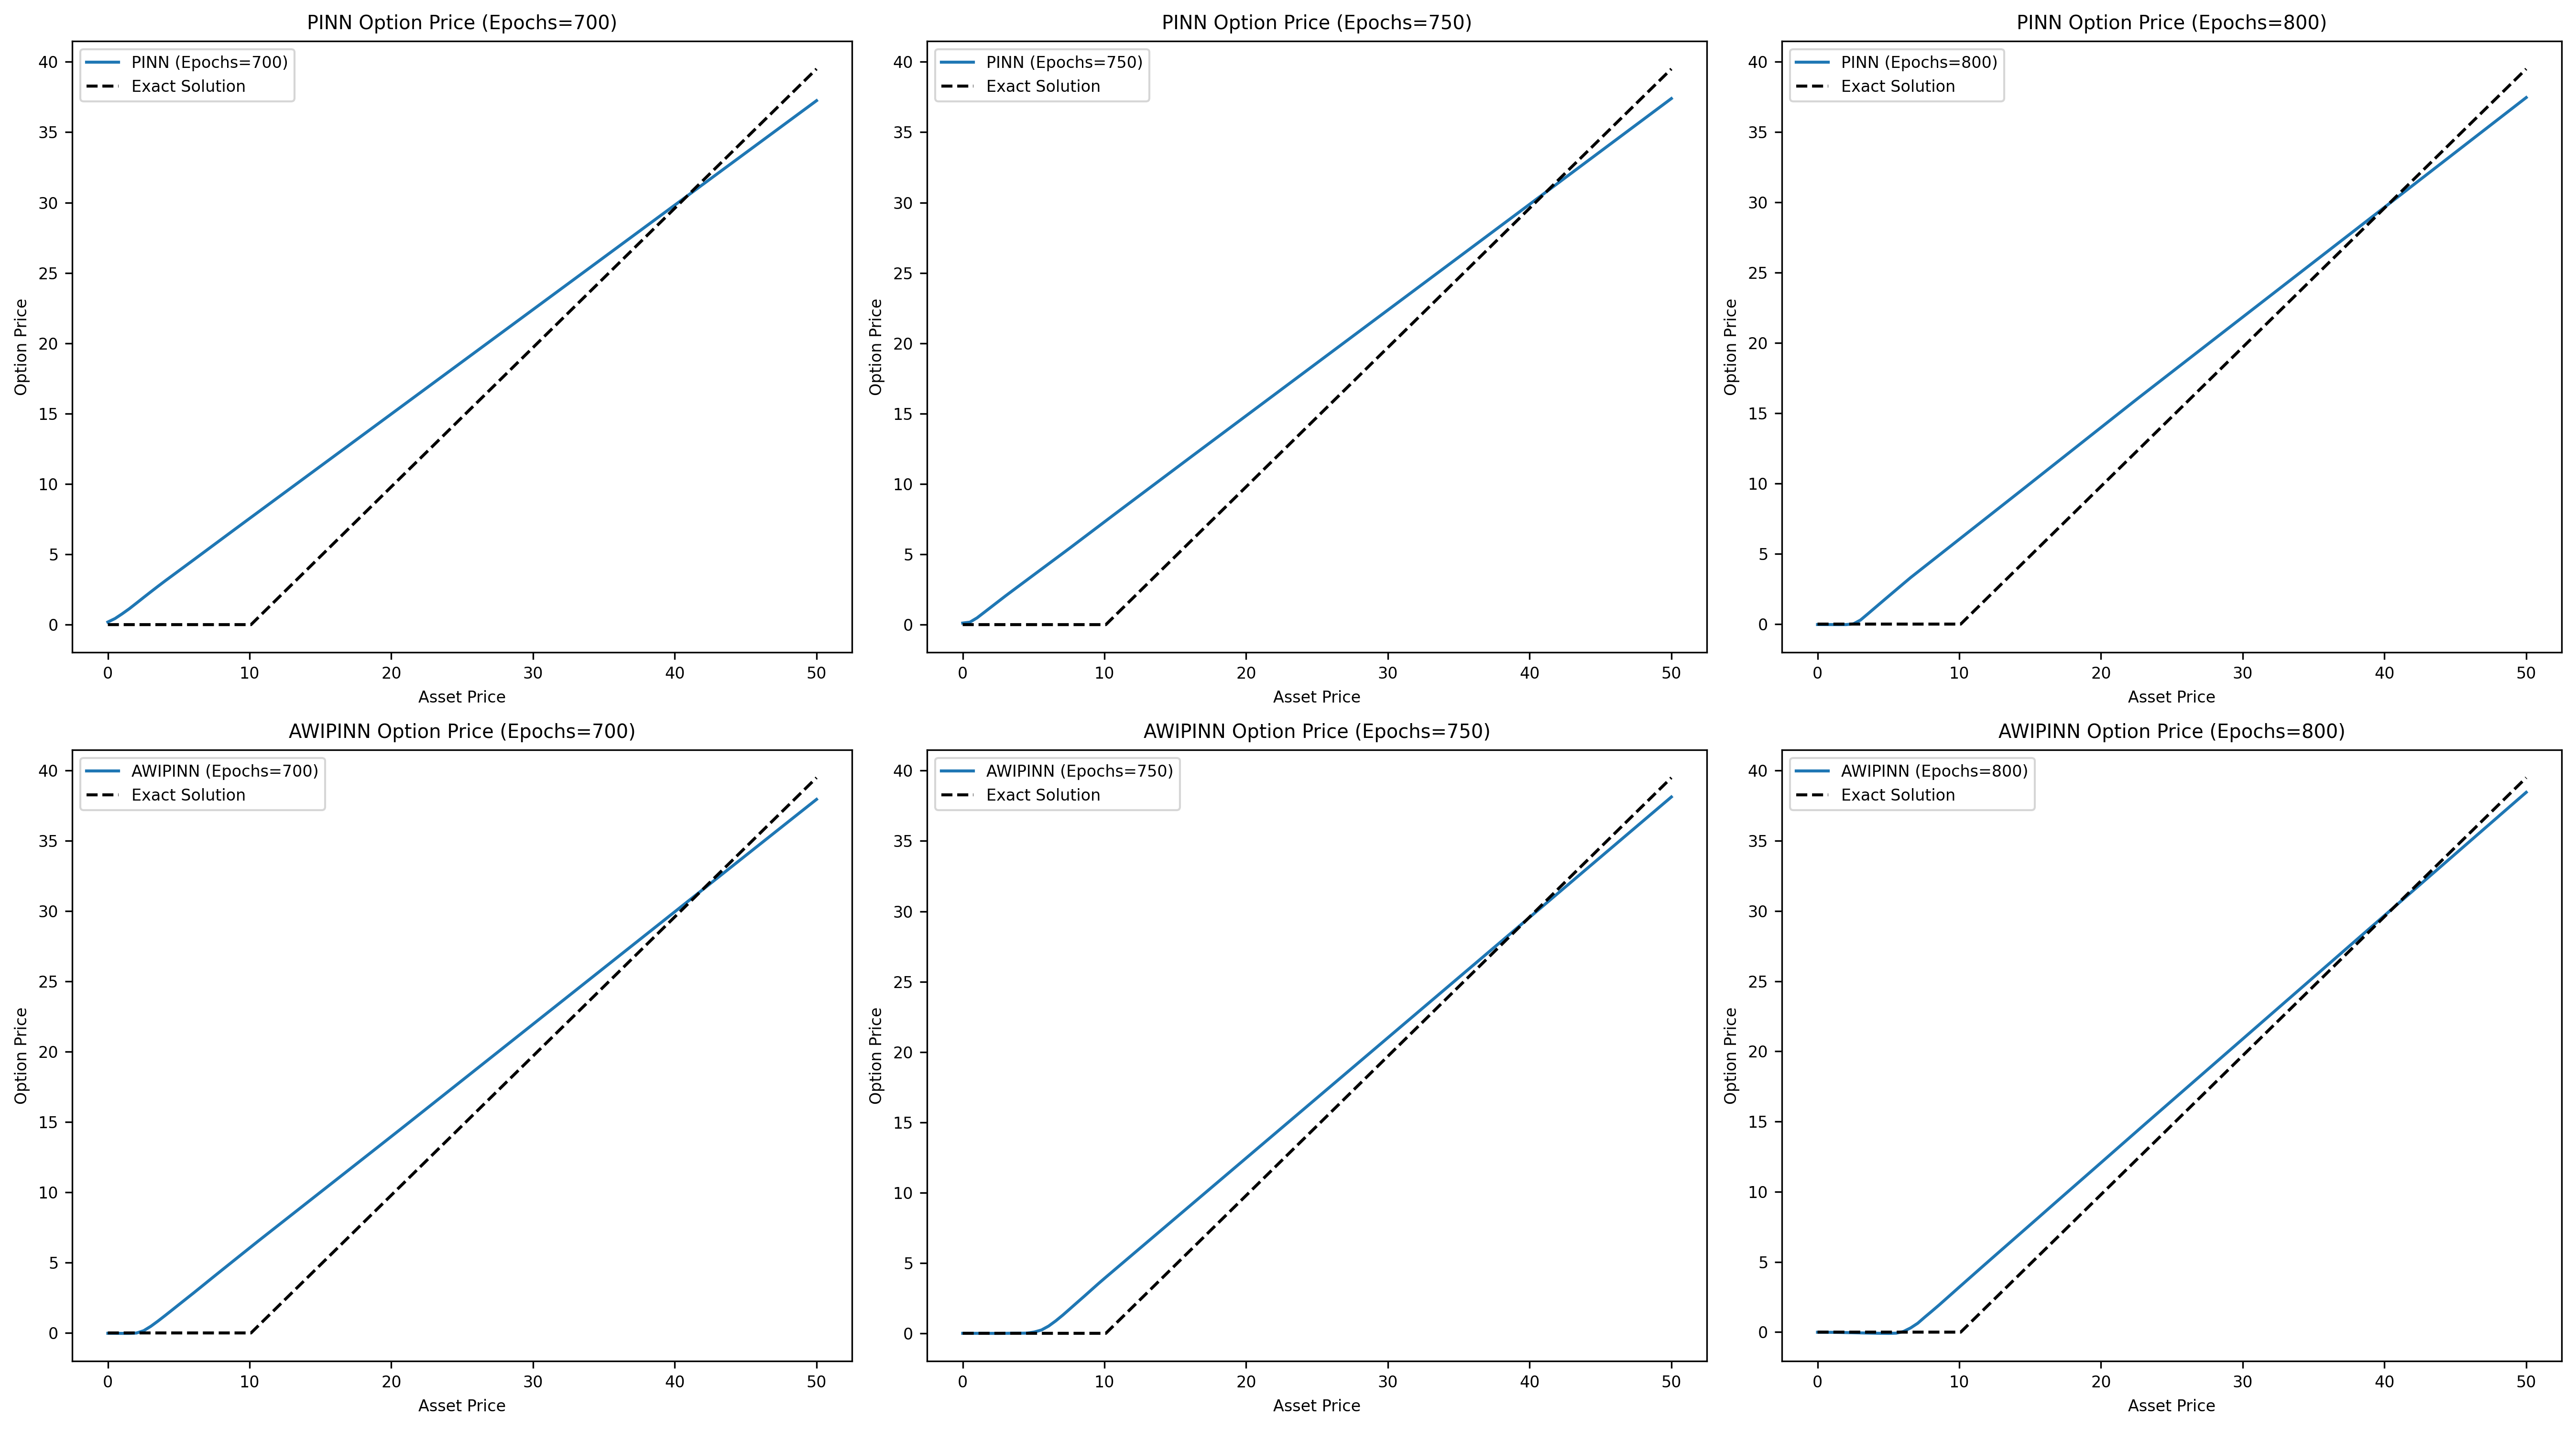

In [48]:
# Define the range of stock prices
stock_prices = np.linspace(0, int(5 * K), 100)  # Example range of stock prices

# Initialize empty lists to store option prices for PINN and AWIPINN models
pinn_option_prices = []
awipinn_option_prices = []

# Iterate over stock prices and calculate option prices for time to maturity = 1
for stock_price in stock_prices:
    # Prepare the input data (time to maturity = 1)
    time_to_maturity = 1
    input_data = torch.tensor([[time_to_maturity, stock_price]], dtype=torch.float32).to(device)

    # Iterate over different epochs for PINN
    for epoch in epochs:
        # Load the PINN model
        pinn = networks.FeedforwardNeuralNetwork(2, 50, 1, 8)
        pinn.to(device)
        pinn.load_state_dict(torch.load(f'pinn_{epoch}.pth'))
        pinn.eval()

        # Make a prediction using the loaded PINN model
        prediction = pinn(input_data)

        # Extract the option price (modify this based on your model's output structure)
        option_price = prediction.item()  # Assuming the model output is a single scalar

        # Append the option price to the list for PINN
        pinn_option_prices.append(option_price)

    # Iterate over different epochs for AWIPINN
    for epoch in epochs:
        # Load the AWIPINN model
        awipinn = networks.ImprovedNeuralNetwork(sizes, 'relu', 0, 0.1, 10.0)
        awipinn.to(device)
        awipinn.load_state_dict(torch.load(f'awipinn_{epoch}.pth'))
        awipinn.eval()

        # Make a prediction using the loaded AWIPINN model
        prediction = awipinn(input_data)

        # Extract the option price (modify this based on your model's output structure)
        option_price = prediction.item()  # Assuming the model output is a single scalar

        # Append the option price to the list for AWIPINN
        awipinn_option_prices.append(option_price)

# Convert the option prices lists to numpy arrays
pinn_option_prices = np.array(pinn_option_prices)
awipinn_option_prices = np.array(awipinn_option_prices)

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot PINN predictions
for i, epoch in enumerate(epochs):
    axes[0, i].plot(stock_prices, pinn_option_prices[i::3], label=f'PINN (Epochs={epoch})')
    axes[0, i].set_xlabel('Asset Price')
    axes[0, i].set_ylabel('Option Price')
    axes[0, i].set_title(f'PINN Option Price (Epochs={epoch})')
    plt.grid()
    axes[0, i].legend()

# Plot AWIPINN predictions
for i, epoch in enumerate(epochs):
    axes[1, i].plot(stock_prices, awipinn_option_prices[i::3], label=f'AWIPINN (Epochs={epoch})')
    axes[1, i].set_xlabel('Asset Price')
    axes[1, i].set_ylabel('Option Price')
    axes[1, i].set_title(f'AWIPINN Option Price (Epochs={epoch})')
    plt.grid()
    axes[1, i].legend()
    
# Overlay the exact solution on all subplots
for i in range(2):
    for j in range(3):
        axes[i, j].plot(stock_prices, exact_solution[0, :], 'k--', label='Exact Solution')
        axes[i, j].legend()

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

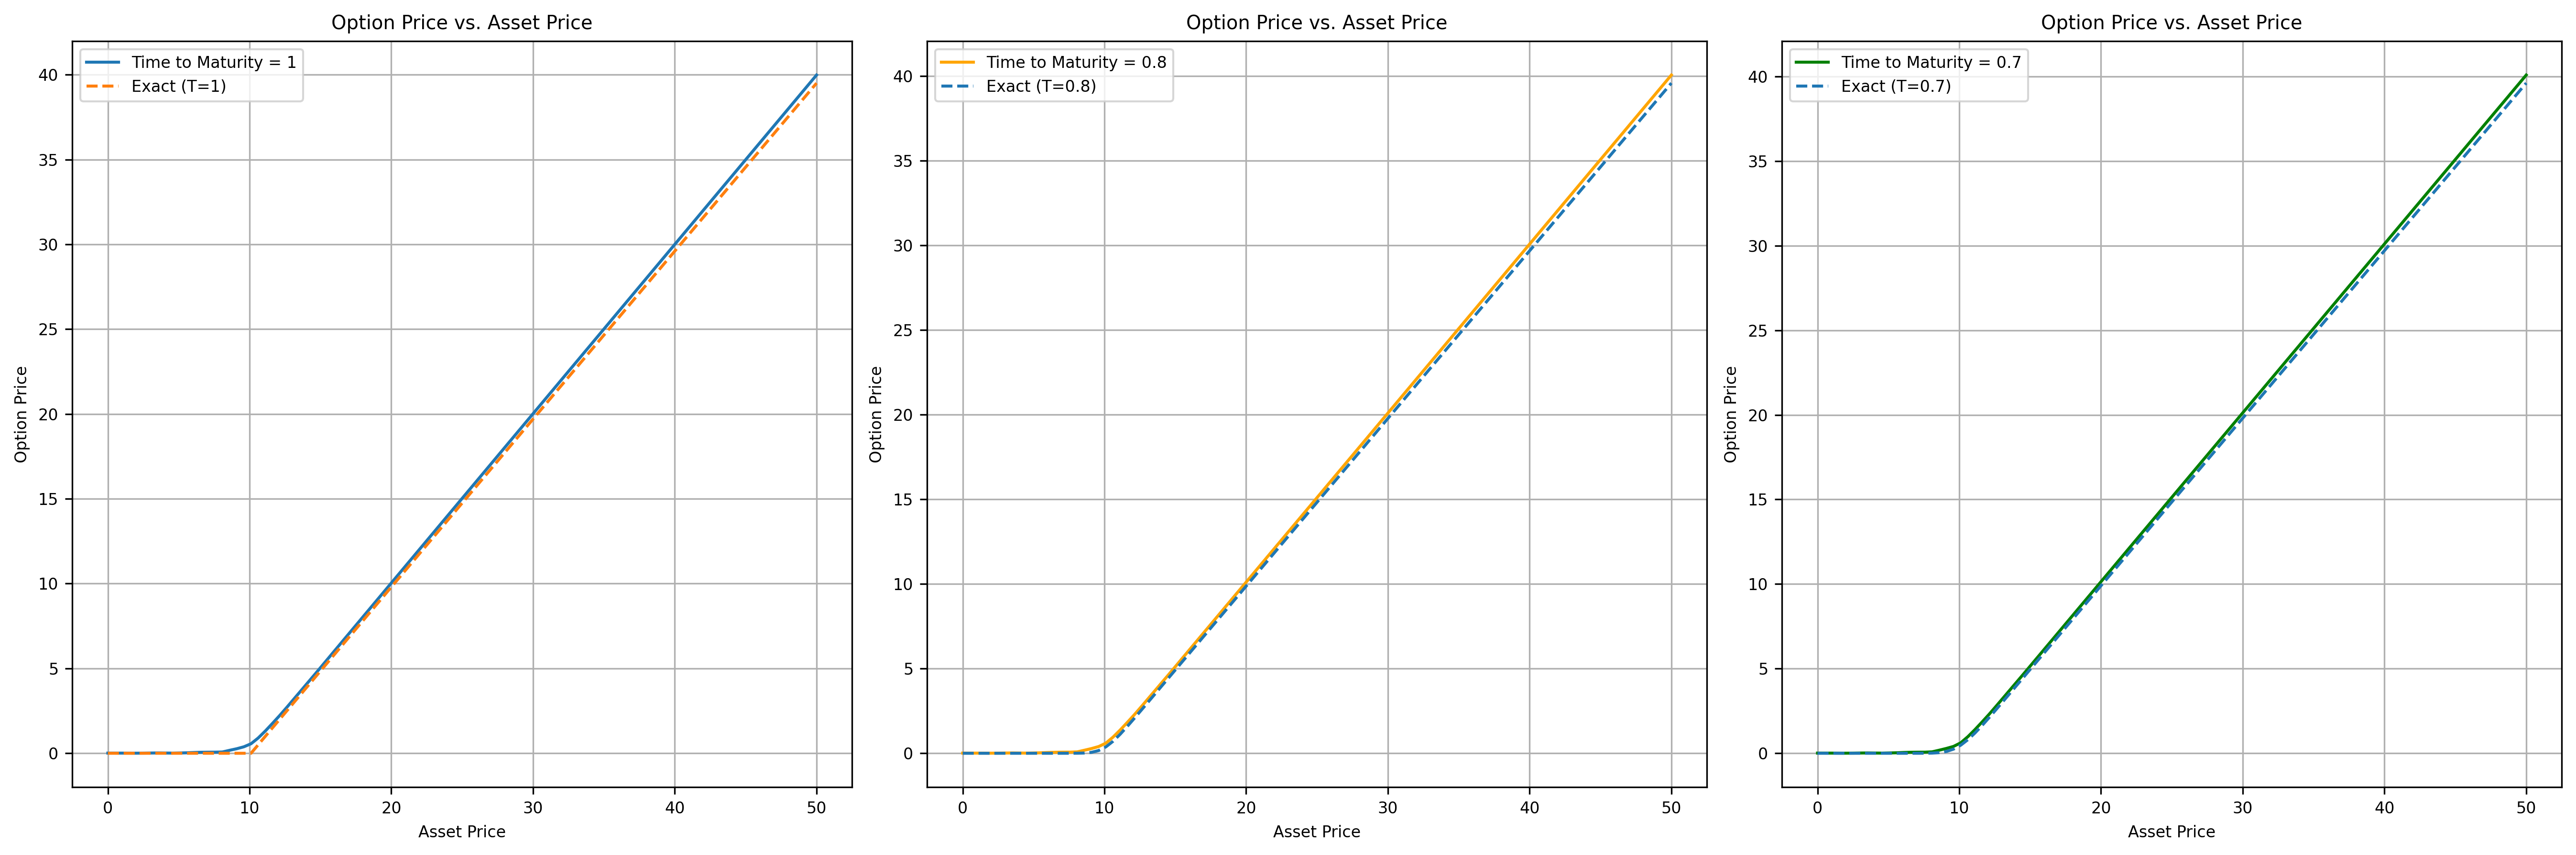

In [33]:
ipinn = networks.ImprovedNeuralNetwork(sizes, 'relu', 0, 0.1, 10.0)
ipinn.to(device)
ipinn.load_state_dict(torch.load('nn.pth'))
ipinn.eval()

# Define the range of stock prices
stock_prices = np.linspace(0, int(5 * K), 100)  # Example range of stock prices

# Initialize an empty list to store option prices
option_prices_1 = []
option_prices_08 = []
option_prices_07 = []

# Iterate over stock prices and calculate option price for different time to maturity values
for stock_price in stock_prices:
    # Prepare the input data for different time to maturity values
    input_data_1 = torch.tensor([[1.0, stock_price]], dtype=torch.float32).to(device)
    input_data_08 = torch.tensor([[0.8, stock_price]], dtype=torch.float32).to(device)
    input_data_07 = torch.tensor([[0.7, stock_price]], dtype=torch.float32).to(device)
    
    # Make predictions using the loaded model for different time to maturity values
    prediction_1 = ipinn(input_data_1)
    prediction_08 = ipinn(input_data_08)
    prediction_07 = ipinn(input_data_07)
    
    # Extract the option prices (modify this based on your model's output structure)
    option_price_1 = prediction_1.item()  # Assuming the model output is a single scalar
    option_price_08 = prediction_08.item()
    option_price_07 = prediction_07.item()
    
    # Append the option prices to their respective lists
    option_prices_1.append(option_price_1)
    option_prices_08.append(option_price_08)
    option_prices_07.append(option_price_07)

# Convert the option prices lists to numpy arrays
option_prices_1 = np.array(option_prices_1)
option_prices_08 = np.array(option_prices_08)
option_prices_07 = np.array(option_prices_07)

# Create a single figure with one row and three columns
plt.figure(figsize=(18, 6))

# First subplot for time to maturity = 1
plt.subplot(131)
plt.plot(stock_prices, option_prices_1, label='Time to Maturity = 1')
plt.plot(stock_prices, exact_solution[0, :], label='Exact (T=1)', linestyle='dashed')
plt.xlabel('Asset Price')
plt.ylabel('Option Price')
plt.title('Option Price vs. Asset Price')
plt.legend()
plt.grid(True)

# Second subplot for time to maturity = 0.8
plt.subplot(132)
plt.plot(stock_prices, option_prices_08, label='Time to Maturity = 0.8', color='orange')
plt.plot(stock_prices, exact_solution[1000, :], label='Exact (T=0.8)', linestyle='dashed')
plt.xlabel('Asset Price')
plt.ylabel('Option Price')
plt.title('Option Price vs. Asset Price')
plt.legend()
plt.grid(True)

# Third subplot for time to maturity = 0.7
plt.subplot(133)
plt.plot(stock_prices, option_prices_07, label='Time to Maturity = 0.7', color='green')
plt.plot(stock_prices, exact_solution[1500, :], label='Exact (T=0.7)', linestyle='dashed')
plt.xlabel('Asset Price')
plt.ylabel('Option Price')
plt.title('Option Price vs. Asset Price')
plt.legend()
plt.grid(True)

# Overlay the exact solution on all subplots
for i in range(2):
    for j in range(3):
        axes[i, j].plot(stock_prices, exact_solution[0, :], 'k--', label='Exact Solution')
        axes[i, j].legend()

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

# Compare Predict and Exact

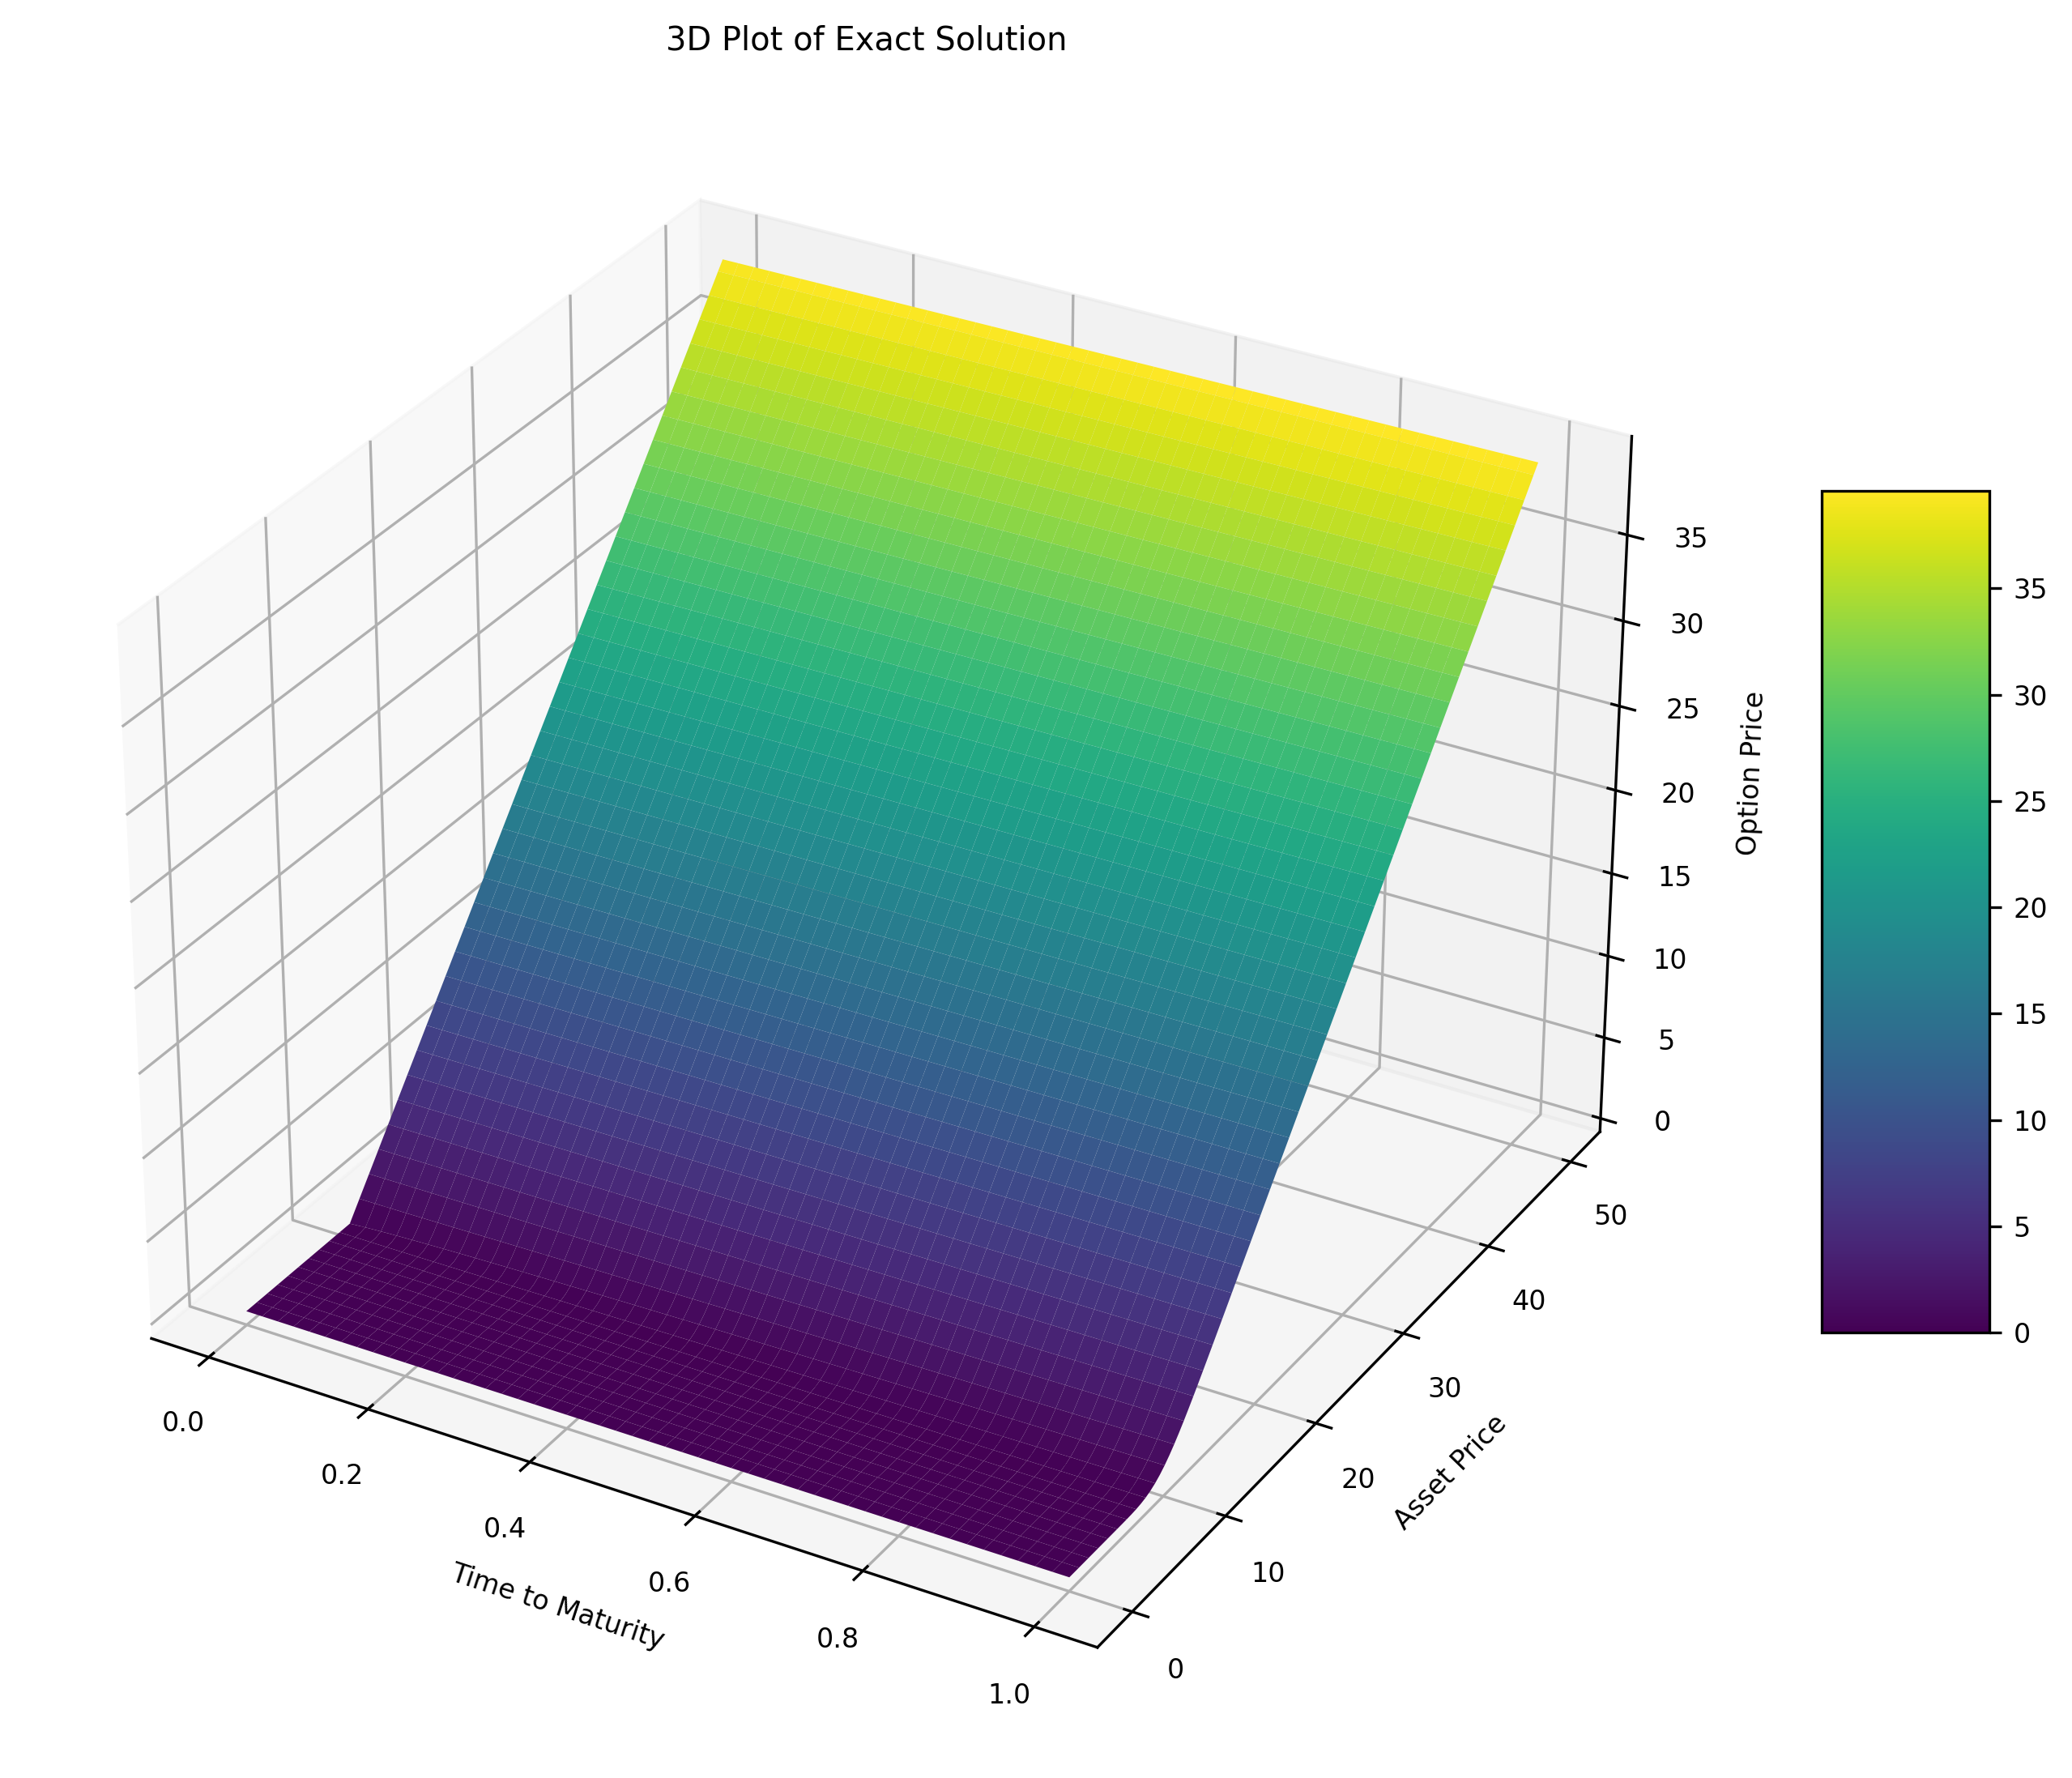

In [7]:
# Extract data for the 3D plot
asset_prices = np.linspace(0, int(5 * K), 100)
time_periods = np.linspace(0, 1, 5000)  # Adjust the number of time steps as needed
X, Y = np.meshgrid(time_periods, asset_prices)
Z = exact_solution.T  # Transpose the exact solution data for correct shape

# Create a 3D figure
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Add labels and title
ax.set_ylabel('Asset Price')
ax.set_xlabel('Time to Maturity')
ax.set_zlabel('Option Price')
ax.set_title('3D Plot of Exact Solution')

# Add a color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5)

# Show the plot
plt.show()

In [49]:
awipinn, min_model, mse_loss_hist, pde_loss_hist, bc_loss_hist, data_loss_hist, loss_weights_hist, relative_l2_hist = utils.network_training(
                K, r, sigma, T, S_range[-1], S_range, t_range, gs, samples['bc'], samples['fc'], samples['pde'], RNG_key=123,
                device=device, net='ipinn', sizes=sizes, activation=activation, learning_rate=lr, aw_learning_rate=0.001, n_epochs=10000, lossFunction=lossFunction, dropout_rate=0, adaptive_rate=0.1, adaptive_rate_scaler=10.0, loss_weights=ipinn_loss_weight, adaptive_weight=True, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor, X_test_tensor=X_test_tensor, y_test_tensor=y_test_tensor
                )

torch.save(min_model, f"nn.pth")  # Save the model's state dictionary

[Training procedure]: 100%|##########| 10000/10000 [04:13<00:00, 39.46it/s]


In [50]:
model = networks.ImprovedNeuralNetwork(sizes, 'relu', 0, 0.1, 10.0)
model.to(device)
model.load_state_dict(torch.load('nn.pth'))
model.eval()
prediction = model(X_test_tensor)
print(lossFunction(prediction, y_test_tensor).item())

# Define the range of stock prices and time periods
stock_prices = np.linspace(0, int(5*K), 50)  # Example range of stock prices
time_periods = np.linspace(0, 1, 50)  # Example range of time periods

# Create a grid of stock prices and time periods
stock_grid, time_grid = np.meshgrid(stock_prices, time_periods)

# Initialize an empty grid for option prices
option_prices = np.zeros_like(stock_grid)

# Populate the option price grid by making predictions
for i in range(stock_grid.shape[0]):
    for j in range(stock_grid.shape[1]):
        stock_price = stock_grid[i, j]
        time_period = time_grid[i, j]
        # Prepare the input data (e.g., convert to PyTorch tensor if needed)
        input_data = torch.tensor([[time_period, stock_price]], dtype=torch.float32).to(device)
        
        # Make a prediction using the loaded model
        prediction = model(input_data)
        
        # Extract the option price (modify this based on your model's output structure)
        option_price = prediction.item()  # Assuming the model output is a single scalar
        
        option_prices[i, j] = option_price

0.006882433779537678


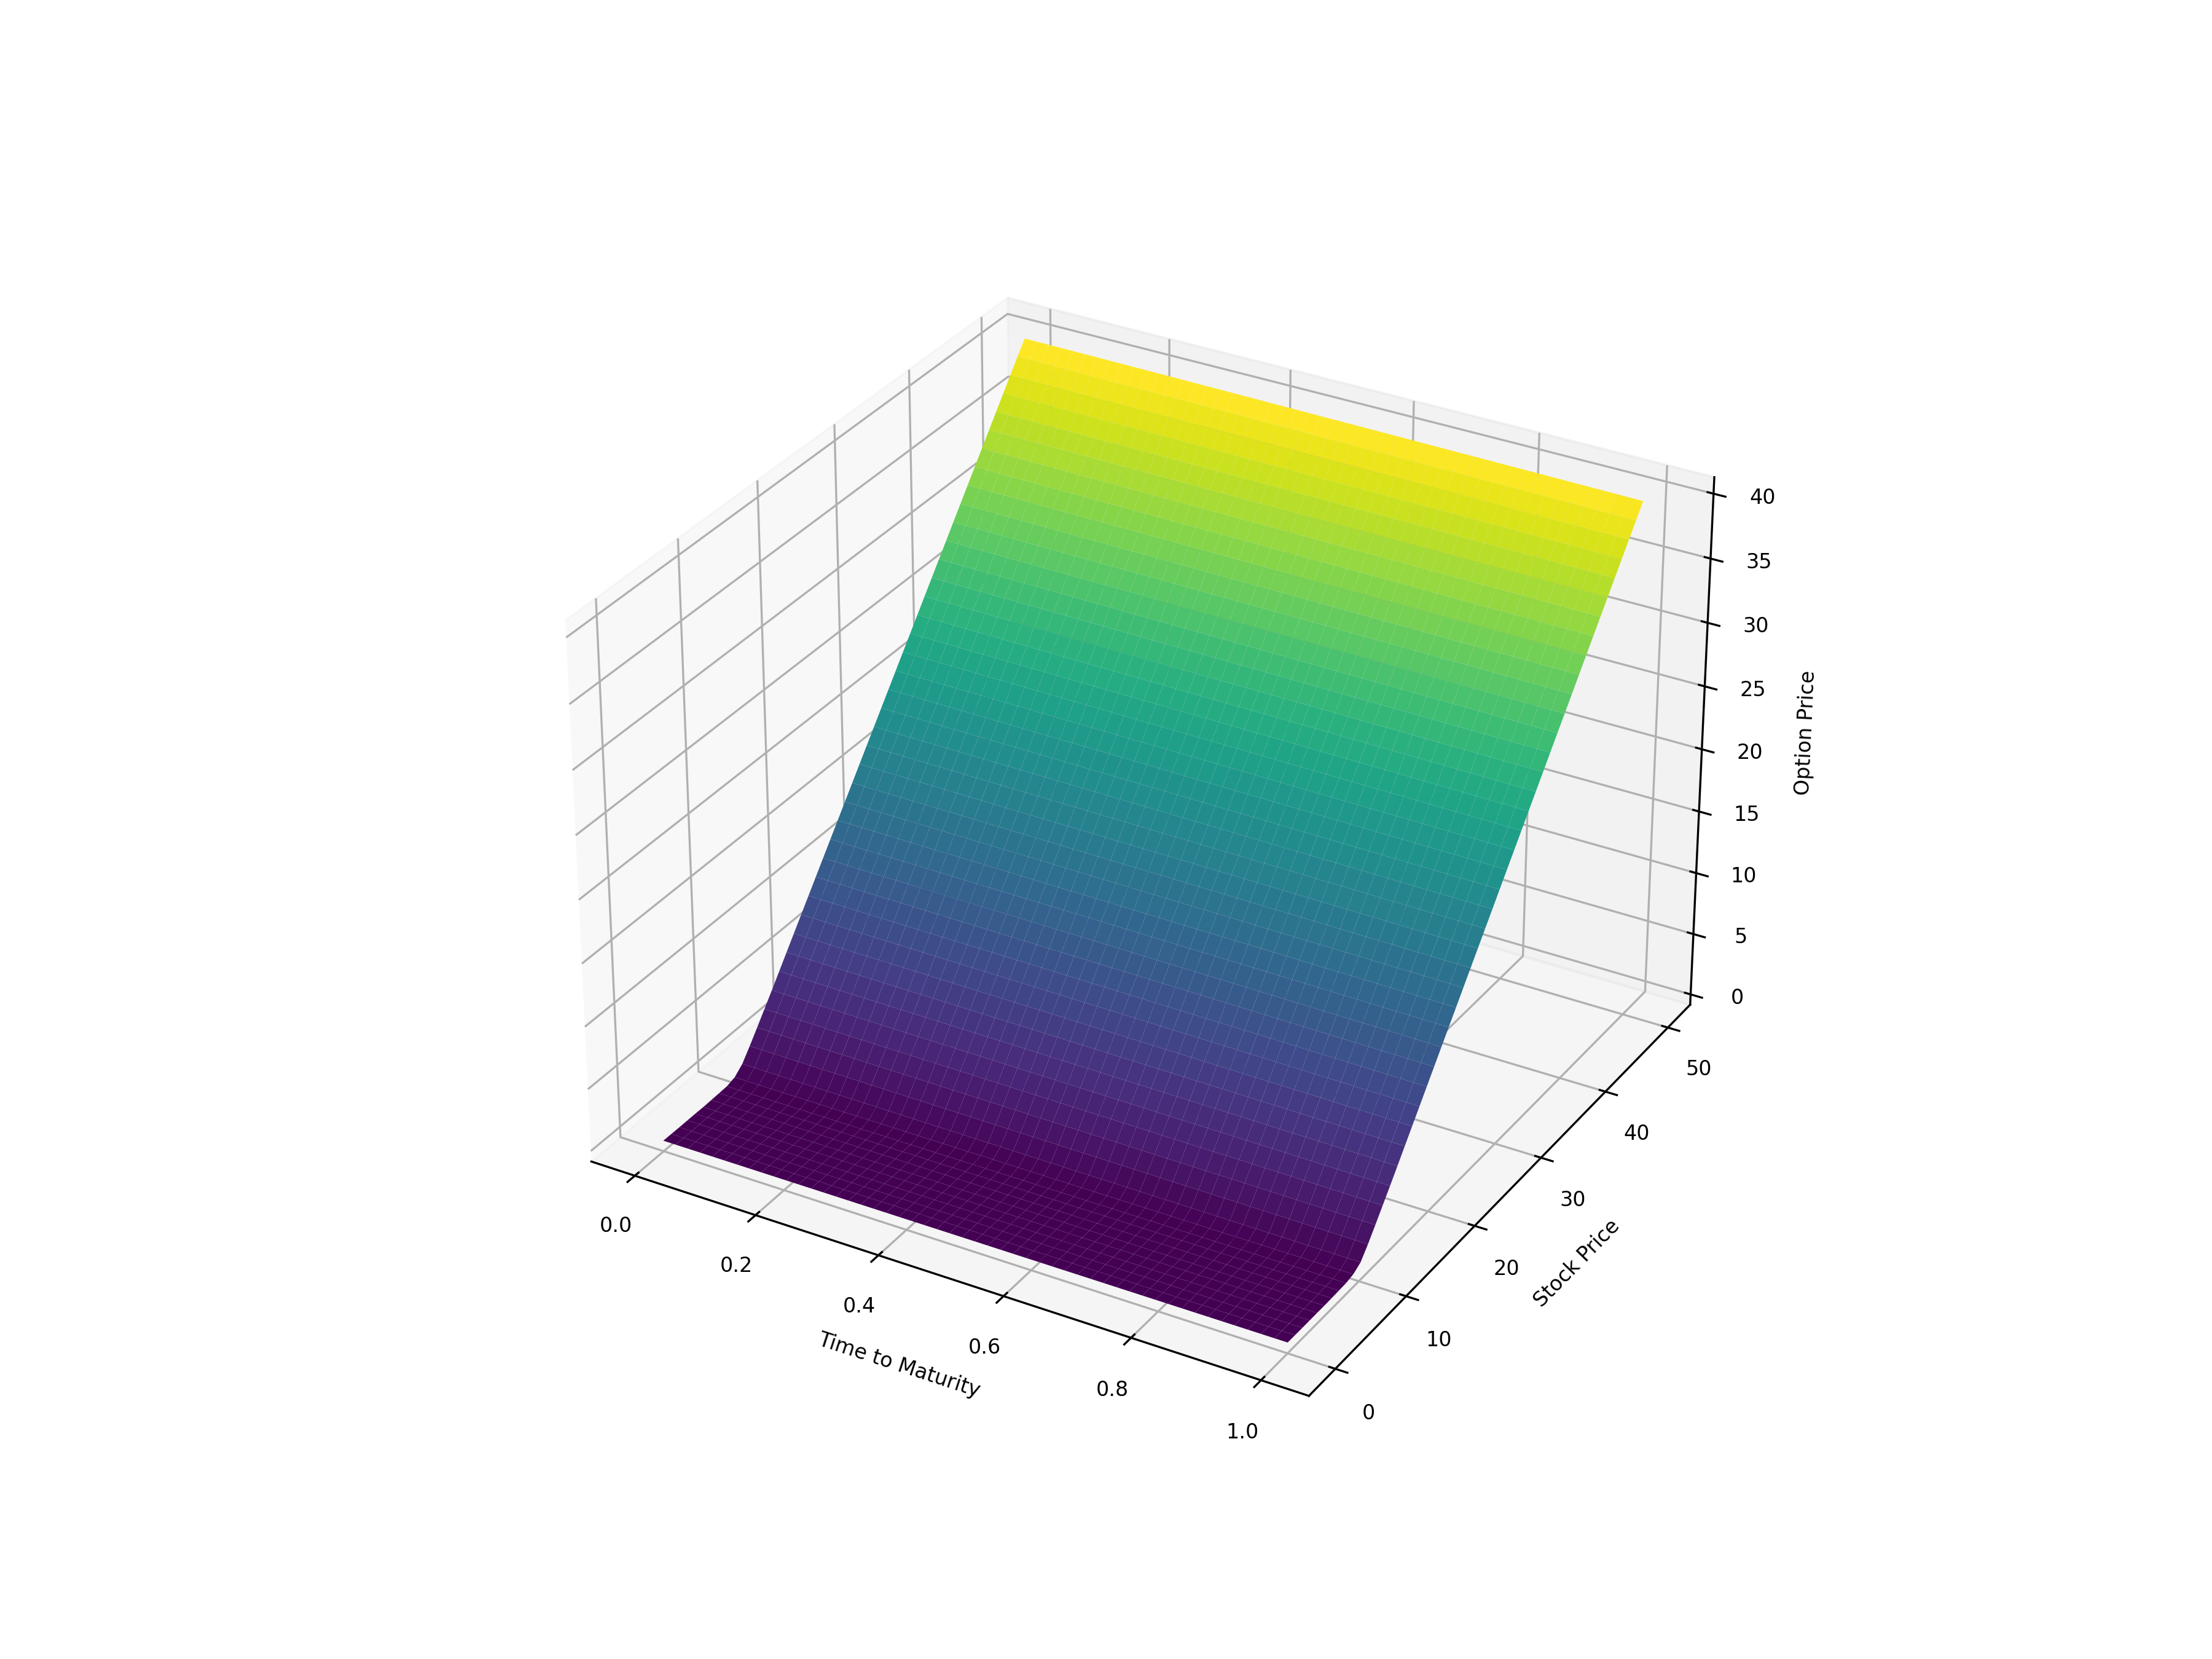

In [51]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
# Create a 3D plot using Axes3D
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(time_grid, stock_grid, option_prices, cmap='viridis')
ax.set_ylabel('Stock Price')
ax.set_xlabel('Time to Maturity')
ax.set_zlabel('Option Price')
# ax.set_aspect('auto')  # 'auto' preserves the aspect ratio
plt.show()